<a href="https://colab.research.google.com/github/AngelDavidRuizB/Trabajos-IA-y-mini-Robots-Angel-David-Ruiz-Barbosa/blob/main/Ejercicios_semana_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicios semana 3

### Ejercicio 1:

x óptimo: 0.851147, f(x) = 1.850594


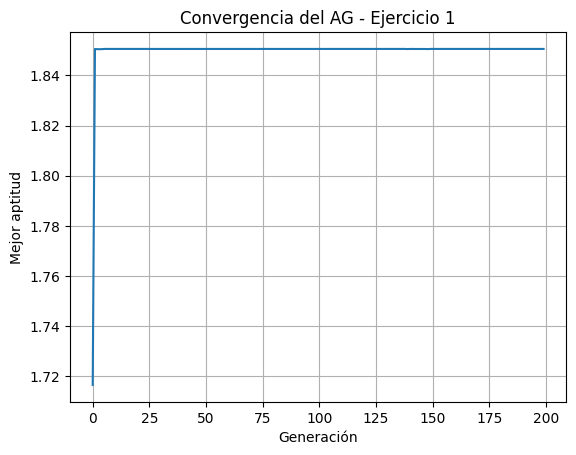

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random, math

def f_aptitud(x):
    return x * math.sin(10 * math.pi * x) + 1

def decodifica(crom, l):
    xi, xf = 0.0, 1.0
    Max = 2**l
    dec = sum(crom[i] * 2**(l - i - 1) for i in range(l))
    return xi + (xf - xi) * dec / (Max - 1)

def genera(l, K):
    return [np.random.randint(0, 2, l).tolist() for _ in range(K)]

def eval_apt(pob, l):
    apt_crom = []
    apt_pob = 0
    for crom in pob:
        x = decodifica(crom, l)
        apt = f_aptitud(x)
        apt_crom.append(apt)
        apt_pob += apt
    probab = [a / apt_pob for a in apt_crom]
    return probab, apt_crom

def seleccion(pob, probab):
    K = len(pob)
    limite = 2 * max(probab)
    pob_nueva, j = [], 0
    while j < K:
        i = 0
        while i < K:
            aleat = random.uniform(0, limite)
            if probab[i] > aleat:
                pob_nueva.append(pob[i])
                j += 1
                if j >= K: break
            i += 1
    return pob_nueva

def cruce(pob_nueva):
    hijos, i = [], 0
    K = len(pob_nueva)
    while i < K - 1:
        c1, c2 = pob_nueva[i], pob_nueva[i+1]
        pt = random.randint(1, len(c1) - 1)
        hijos.append(c1[:pt] + c2[pt:])
        hijos.append(c2[:pt] + c1[pt:])
        i += 2
    return hijos

def mutacion(hijos, pm, l):
    K = len(hijos)
    total = K * l
    n_mut = int(total * pm)
    for _ in range(n_mut):
        x = random.randint(0, K - 1)
        y = random.randint(0, l - 1)
        hijos[x][y] = 1 - hijos[x][y]
    return hijos

# Parámetros
l, K, M, pm = 20, 50, 200, 0.01
pob = genera(l, K)
mejor_hist = []

for gen in range(M):
    probab, apt_crom = eval_apt(pob, l)
    mejor = max(apt_crom)
    mejor_hist.append(mejor)
    n_pob = seleccion(pob, probab)
    hijos = cruce(n_pob)
    pob = mutacion(hijos, pm, l)

# Mejor solución final
probab, apt_crom = eval_apt(pob, l)
idx = apt_crom.index(max(apt_crom))
x_opt = decodifica(pob[idx], l)
print(f"x óptimo: {x_opt:.6f}, f(x) = {f_aptitud(x_opt):.6f}")

plt.plot(mejor_hist)
plt.xlabel("Generación")
plt.ylabel("Mejor aptitud")
plt.title("Convergencia del AG - Ejercicio 1")
plt.grid(True)
plt.show()

### Ejercicio 3:

In [6]:
import numpy as np
import random

# Datos del problema
costo_transp = np.array([
    [1, 4, 3, 6],   # Planta C
    [4, 1, 4, 5],   # Planta B
    [3, 4, 1, 4],   # Planta M
    [6, 5, 4, 1]    # Planta Ba
], dtype=float)

costo_gen = np.array([680, 720, 660, 750], dtype=float)
capacidad = np.array([3, 6, 5, 4], dtype=float)
demanda   = np.array([4, 3, 5, 3], dtype=float)

def costo_total(x):
    return np.sum(x * costo_transp) + np.sum(x, axis=1) @ costo_gen

def penalidad(x):
    pen = 0
    for i in range(4):
        pen += max(0, x[i].sum() - capacidad[i]) * 10000
    for j in range(4):
        pen += abs(x[:, j].sum() - demanda[j]) * 10000
    return pen

def f_aptitud(crom):
    x = np.array(crom).reshape(4, 4)
    c = costo_total(x) + penalidad(x)
    return 1.0 / (1.0 + c)

def genera_crom():
    # Genera un cromosoma factible respetando demandas
    x = np.zeros((4, 4))
    dem_rest = demanda.copy()
    cap_rest = capacidad.copy()
    for j in range(4):
        for i in range(4):
            maximo = min(cap_rest[i], dem_rest[j])
            if i == 3:  # última planta, asigna lo que falta
                val = dem_rest[j]
            else:
                val = round(random.uniform(0, maximo), 1)
            val = min(val, cap_rest[i], dem_rest[j])
            x[i][j] = val
            dem_rest[j] -= val
            cap_rest[i] -= val
    return x.flatten().tolist()

def genera_pob(K):
    return [genera_crom() for _ in range(K)]

def eval_apt(pob):
    apt = [f_aptitud(c) for c in pob]
    s = sum(apt)
    return [a/s for a in apt], apt

def seleccion(pob, probab):
    K = len(pob)
    lim = 2 * max(probab)
    nueva, j = [], 0
    while j < K:
        for i in range(K):
            if random.uniform(0, lim) < probab[i]:
                nueva.append(pob[i][:])
                j += 1
                if j >= K: break
    return nueva

def cruce(pob):
    hijos, i = [], 0
    while i < len(pob) - 1:
        p1, p2 = pob[i], pob[i+1]
        pt1, pt2 = sorted(random.sample(range(1, 16), 2))
        h1 = p1[:pt1] + p2[pt1:pt2] + p1[pt2:]
        h2 = p2[:pt1] + p1[pt1:pt2] + p2[pt2:]
        hijos.extend([h1, h2])
        i += 2
    return hijos

def mutacion(hijos, pm=0.05):
    for crom in hijos:
        for j in range(len(crom)):
            if random.random() < pm:
                crom[j] = max(0, crom[j] + random.uniform(-0.5, 0.5))
    return hijos

# Ejecución del AG
K, M = 200, 500
pob = genera_pob(K)
mejor_hist = []

for gen in range(M):
    probab, apt_crom = eval_apt(pob)
    mejor_hist.append(max(apt_crom))
    n_pob = seleccion(pob, probab)
    hijos = cruce(n_pob)
    pob = mutacion(hijos)

# Resultado
probab, apt_crom = eval_apt(pob)
mejor = pob[apt_crom.index(max(apt_crom))]
x_opt = np.array(mejor).reshape(4, 4)

ciudades = ["Cali", "Bogotá", "Medellín", "Barranquilla"]
plantas  = ["Planta C", "Planta B", "Planta M", "Planta Ba"]

print("\nDespacho óptimo (GW):")
print(f"{'':12}", end="")
for c in ciudades: print(f"{c:>12}", end="")
print()
for i, p in enumerate(plantas):
    print(f"{p:12}", end="")
    for j in range(4): print(f"{x_opt[i][j]:>12.2f}", end="")
    print()

print(f"\nCosto de transporte: {np.sum(x_opt * costo_transp):.2f}")
print(f"Costo de generación: {np.sum(x_opt, axis=1) @ costo_gen:.2f}")
print(f"Costo total:         {costo_total(x_opt):.2f}")
print(f"Penalidad:           {penalidad(x_opt):.2f}")


Despacho óptimo (GW):
                    Cali      Bogotá    MedellínBarranquilla
Planta C            1.86        0.02        0.00        0.25
Planta B            0.90        1.52        2.74        0.37
Planta M            0.74        1.41        0.01        1.78
Planta Ba           0.54        0.00        2.23        0.47

Costo de transporte: 48.98
Costo de generación: 10461.10
Costo total:         10510.08
Penalidad:           2525.99


### Ejercicio 4:

Cargando imagen objetivo...


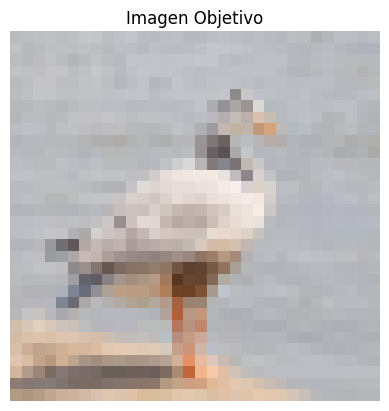

Generando población inicial...
Generación 0 | Mejor error (MAE): 75.71


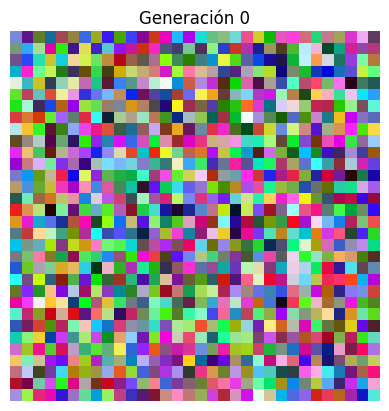

Generación 500 | Mejor error (MAE): 51.05


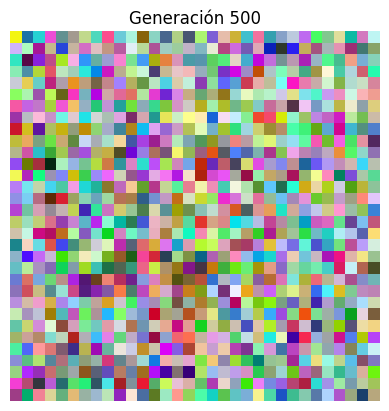

Generación 1000 | Mejor error (MAE): 49.40


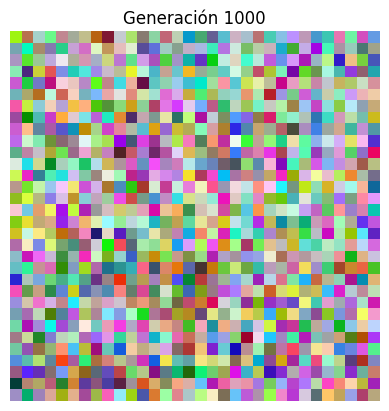

Generación 1500 | Mejor error (MAE): 48.49


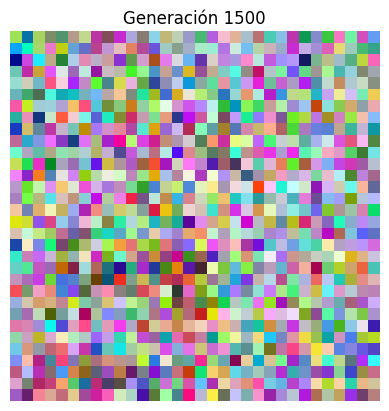

Generación 2000 | Mejor error (MAE): 47.58


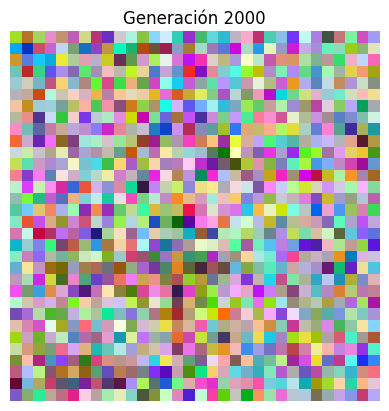

Generación 2500 | Mejor error (MAE): 47.19


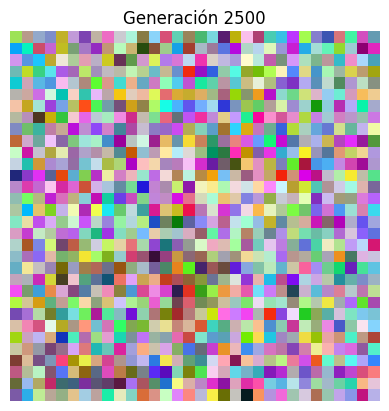

Generación 3000 | Mejor error (MAE): 46.24


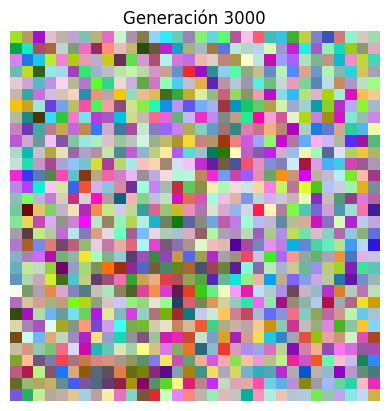

Generación 3500 | Mejor error (MAE): 46.06


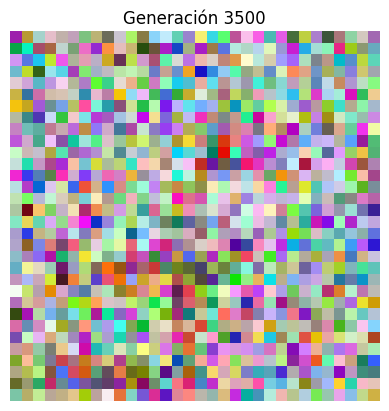

Generación 4000 | Mejor error (MAE): 46.04


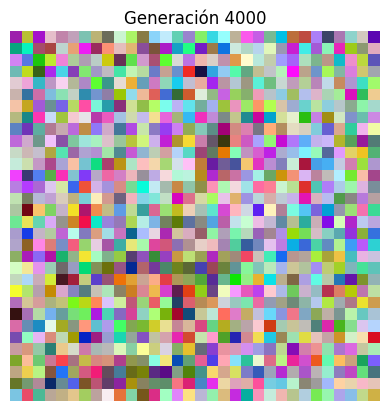

Generación 4500 | Mejor error (MAE): 45.73


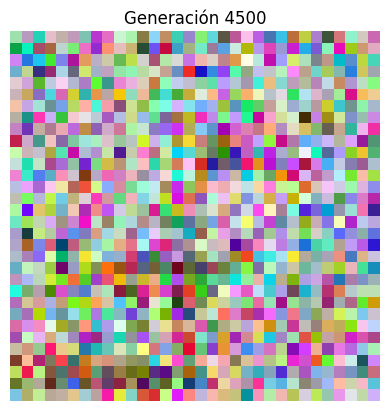

Generación 4999 | Mejor error (MAE): 45.73


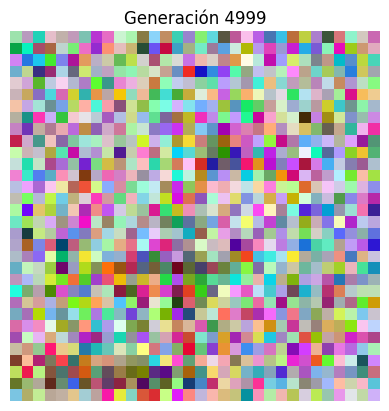

Evolución terminada.


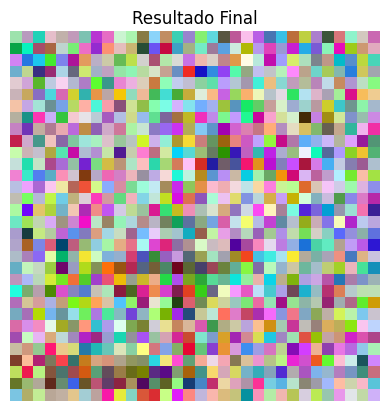

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# PARÁMETROS DEL ALGORITMO GENÉTICO

TAMANO_IMAGEN = (32, 32)
TAMANO_POBLACION = 100
GENERACIONES = 5000
TASA_MUTACION = 0.05
ELITISMO = 0.2

# FUNCIONES

def cargar_imagen(ruta):
    """Carga la imagen, la redimensiona y la convierte en un arreglo plano (cromosoma)."""
    img = Image.open(ruta).convert('RGB')
    img = img.resize(TAMANO_IMAGEN)

    return np.array(img, dtype=np.int16).flatten()

def mostrar_individuo(individuo, titulo="Imagen"):
    """Convierte el cromosoma plano en imagen RGB y la muestra."""
    # Asegurar que los valores estén en el rango válido [0, 255]
    img_matriz = np.clip(individuo, 0, 255).astype(np.uint8)
    img_matriz = img_matriz.reshape((TAMANO_IMAGEN[1], TAMANO_IMAGEN[0], 3))

    plt.imshow(img_matriz)
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# OPERACIONES DEL ALGORITMO GENETICO

def crear_poblacion(tamano_pob, longitud_cromosoma):
    """Genera matrices iniciales aleatorias con números de 0 a 255."""
    return np.random.randint(0, 256, (tamano_pob, longitud_cromosoma), dtype=np.int16)

def calcular_aptitud(poblacion, objetivo):
    """Calcula el Error Absoluto de cada individuo con respecto a la imagen objetivo."""

    errores = np.mean(np.abs(poblacion - objetivo), axis=1)
    return errores

def cruzar(padre1, padre2):
    """Cruce uniforme: selecciona aleatoriamente de qué padre heredar cada píxel."""
    mascara = np.random.rand(len(padre1)) > 0.5
    hijo = np.where(mascara, padre1, padre2)
    return hijo

def mutar(hijo, tasa_mutacion):
    """Altera píxeles aleatorios asignando un nuevo valor RGB."""
    mascara_mutacion = np.random.rand(len(hijo)) < tasa_mutacion
    mutaciones = np.random.randint(0, 256, len(hijo), dtype=np.int16)
    hijo = np.where(mascara_mutacion, mutaciones, hijo)
    return hijo

# CICLO DONDE SE EJECUTARA EL CODIGO
def ejecutar_ag(ruta_imagen):
    print("Cargando imagen objetivo...")
    objetivo = cargar_imagen(ruta_imagen)
    longitud_cromosoma = len(objetivo)


    mostrar_individuo(objetivo, "Imagen Objetivo")


    print("Generando población inicial...")
    poblacion = crear_poblacion(TAMANO_POBLACION, longitud_cromosoma)

    num_elite = int(TAMANO_POBLACION * ELITISMO)


    for generacion in range(GENERACIONES):
        # 1. Evaluar aptitud
        errores = calcular_aptitud(poblacion, objetivo)

        # 2. Ordenar población de menor a mayor error
        indices_ordenados = np.argsort(errores)
        poblacion = poblacion[indices_ordenados]

        # Mostrar progreso
        if generacion % 500 == 0 or generacion == GENERACIONES - 1:
            mejor_error = errores[indices_ordenados[0]]
            print(f"Generación {generacion} | Mejor error (MAE): {mejor_error:.2f}")
            mostrar_individuo(poblacion[0], f"Generación {generacion}")

        # Si la imagen es perfecta, detener
        if errores[indices_ordenados[0]] == 0:
            print(f"¡Convergencia perfecta en la generación {generacion}!")
            break

        # 3. Selección y Elitismo
        nueva_poblacion = []
        nueva_poblacion.extend(poblacion[:num_elite])

        # 4. Cruce y Mutación para el resto de la población
        while len(nueva_poblacion) < TAMANO_POBLACION:

            padre1 = poblacion[np.random.randint(0, num_elite)]
            padre2 = poblacion[np.random.randint(0, num_elite)]

            hijo = cruzar(padre1, padre2)
            hijo = mutar(hijo, TASA_MUTACION)

            nueva_poblacion.append(hijo)

        poblacion = np.array(nueva_poblacion)

    print("Evolución terminada.")
    mostrar_individuo(poblacion[0], "Resultado Final")

ejecutar_ag('/content/Pato.jpg')